# **Vision Transformer**
<hr>

The Vision Transformer (ViT) model was introduced in a research paper published as a conference paper at ICLR 2021 titled “An Image is Worth 16*16 Words: Transformers for Image Recognition at Scale”.

Link: https://arxiv.org/pdf/2010.11929.pdf

It is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder.

**Architecture**

The overall architecture of the vision transformer model is as follows:
- An image is divided into small patches here let’s say 9, and each patch might contain 16×16 pixels.  
- The input sequence consists of a flattened vector of pixel values from a patch of size 16×16.
- Each flattened element is fed into a linear projection layer that will produce the “Patch embedding”.
- Position embeddings are then linearly added to the sequence of image patches so that the images can retain their positional information.
- It adds information about the relative or absolute position of the image patches in the sequence.
- An extra learnable embedding (class embedding) is attached to the sequence according to the position of the image patch.
- This class embedding is used to predict the class of the input image after being updated by self-attention.
- Sequence is fed into a standard transformer encoder.
- The classification is performed by just stacking an MLP Head on top of the Transformer, at the position of the extra learnable embedding that we added to the sequence.

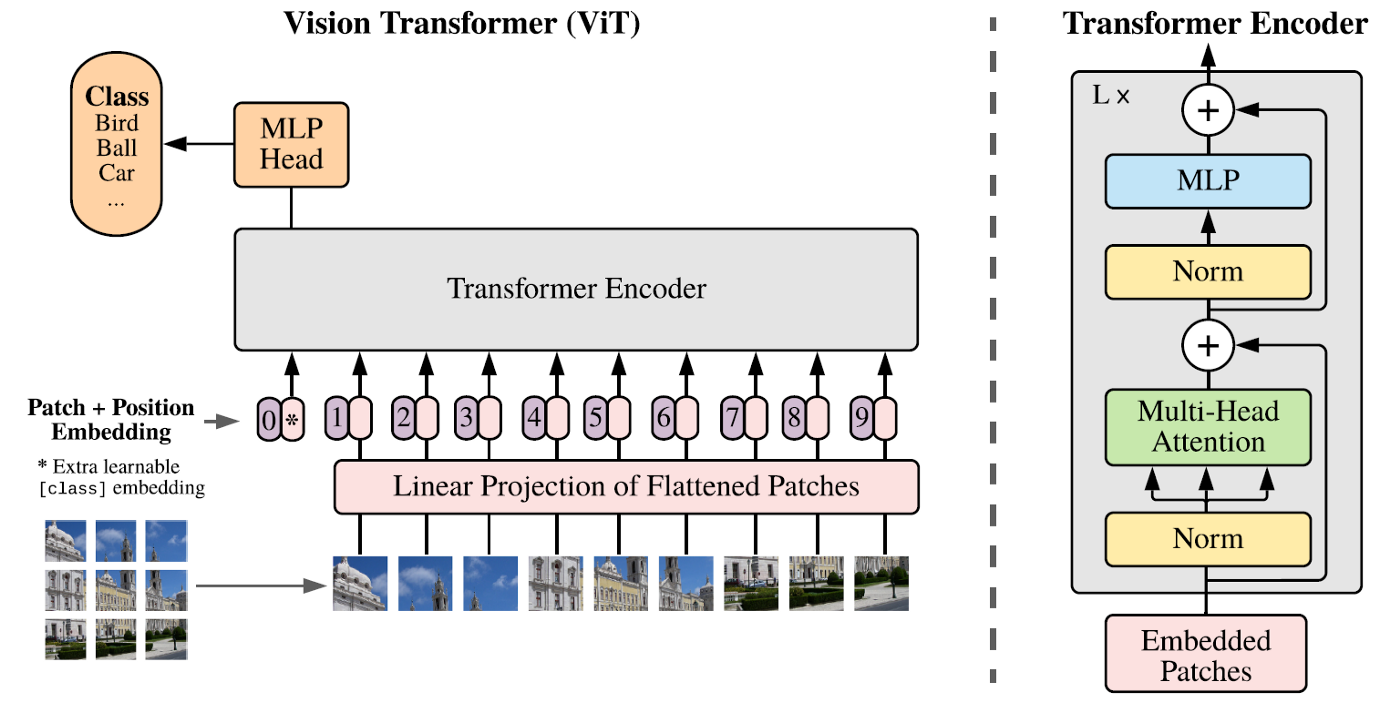

Taken from: [“An Image is Worth 16*16 Words: Transformers for Image Recognition at Scale”](https://arxiv.org/pdf/2010.11929.pdf)

## 0. Setup

In [ ]:
import torch
import torchvision

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3107 (delta 14), reused 24 (delta 8), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 25.99 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Getting Data

In [ ]:
# Downloading pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setting up directory paths to train & test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Creating Datasets and Dataloaders

### 2.1 Prepare transforms for images

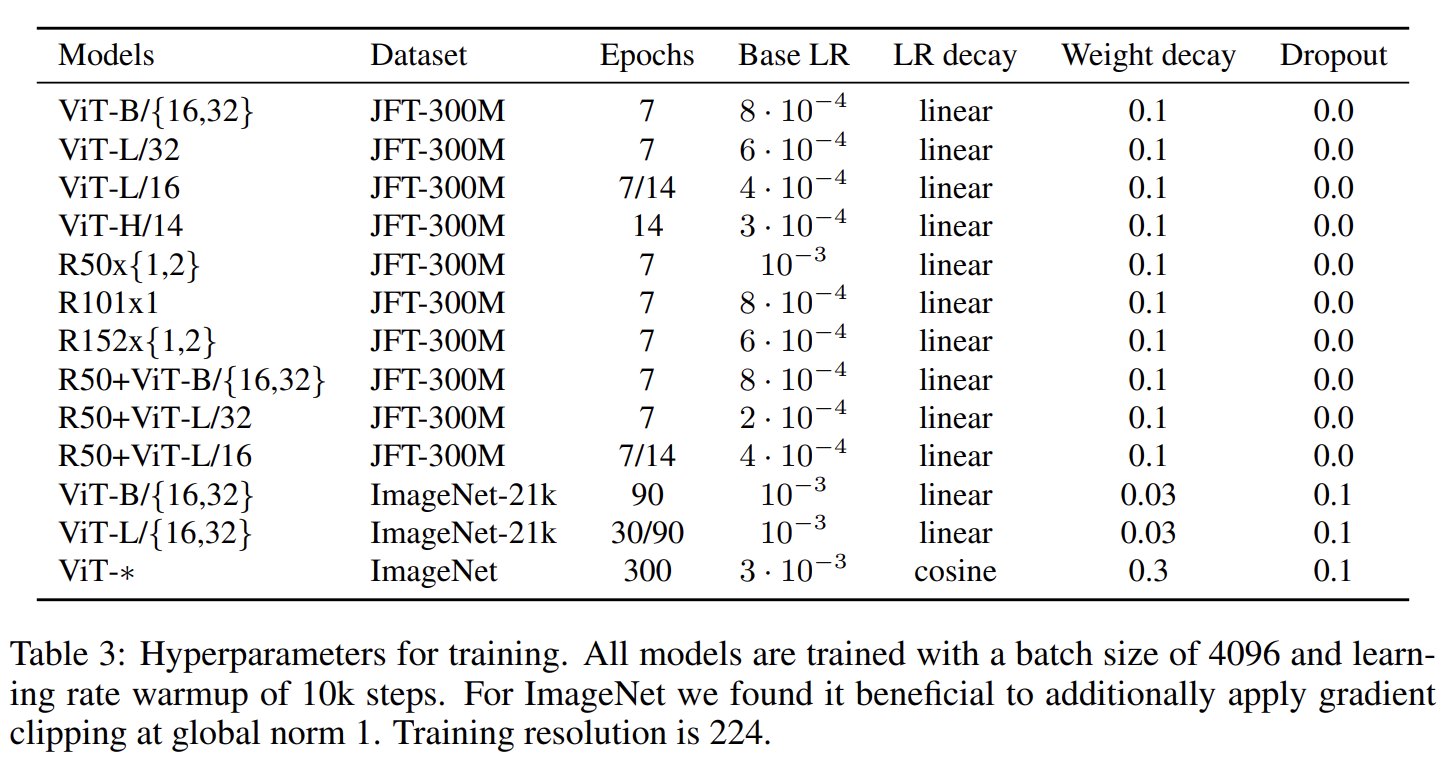

In [ ]:
# Create image size (from Table 3 in the paper)
IMG_SIZE = 224

# Create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


### 2.2 Turning images into Dataloaders

In [ ]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f41f9b23f50>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize

In [ ]:
# Getting a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

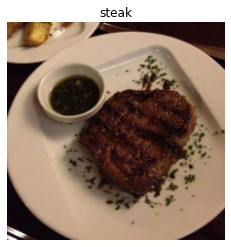

In [ ]:
# Plotting
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT Paper

AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE

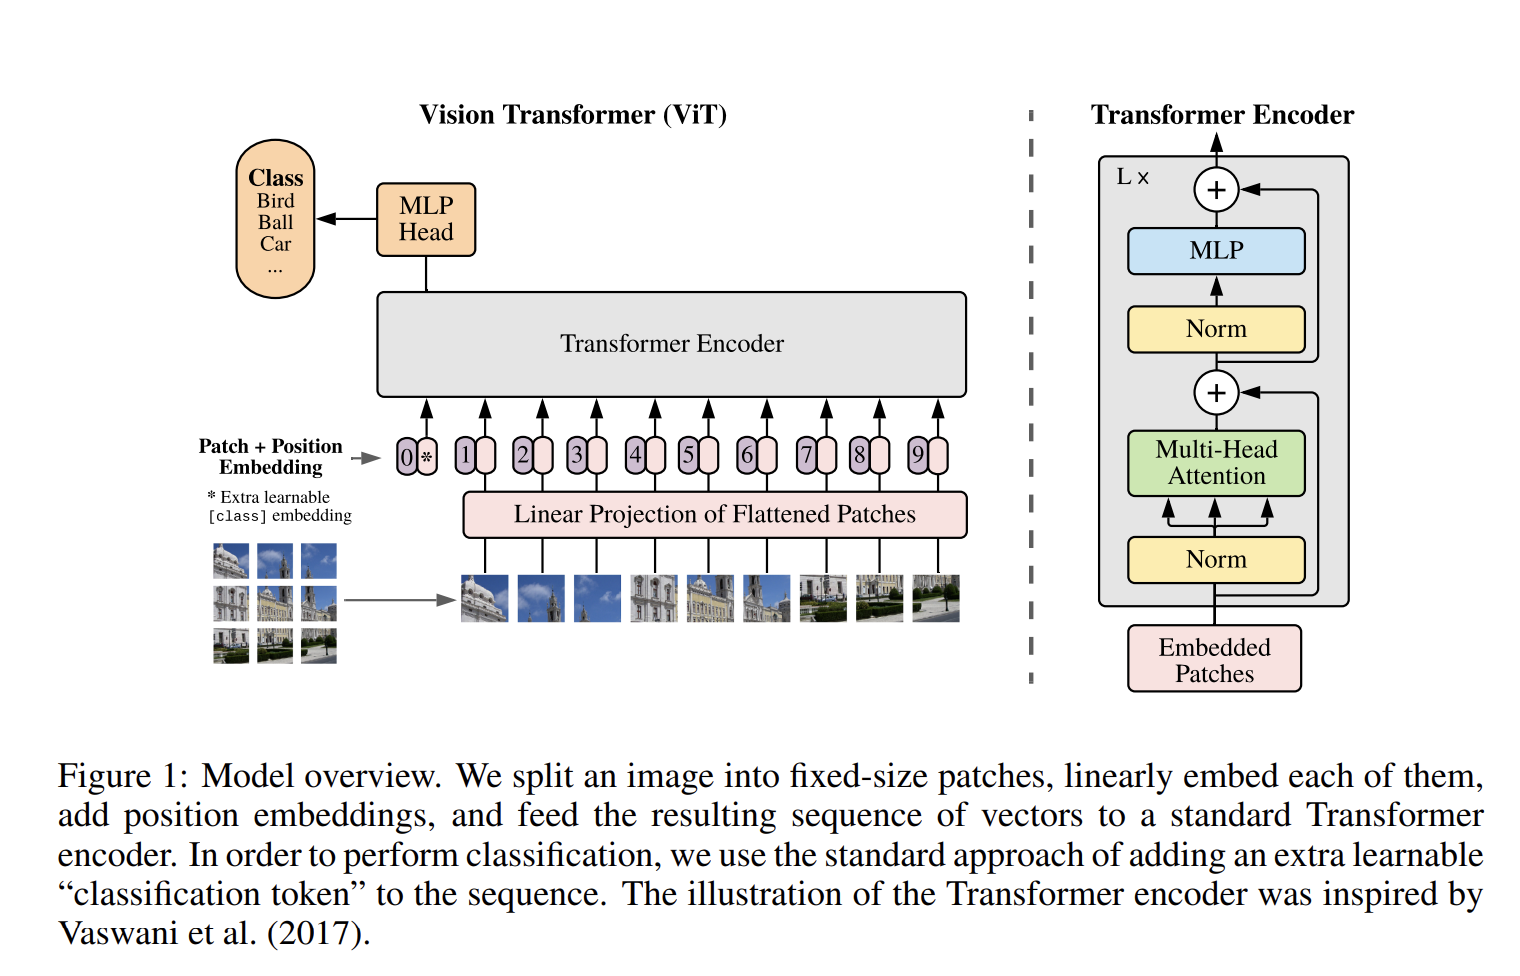

**Equations**

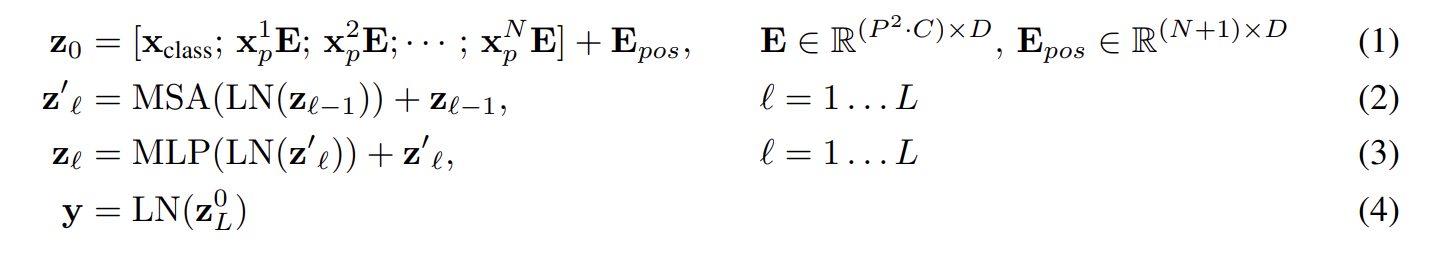

## **4. Equation 1: Split data into patches and create the class, position and patch embedding**

**Section 3.1**
> The standard Transformer receives as input a 1D
sequence of token embeddings. To handle 2D images, we reshape the image x ∈ R
H×W×C into a
sequence of flattened 2D patches xp ∈ R
N×(P
2
·C)
, where (H, W) is the resolution of the original
image, C is the number of channels, (P, P) is the resolution of each image patch, and N = HW/P2
is the resulting number of patches, which also serves as the effective input sequence length for the
Transformer. The Transformer uses constant latent vector size D through all of its layers, so we
flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to
the output of this projection as the patch embeddings.

> The training resolution is 224.

Breaking the above section down:

- D is size of patch embeddings.
- Initial Image size is H x W x C.
- The image gets converted to a sequence of flattened 2D patches with size N x (P^2.C).
- (P,P) is the resolution of each image patch (patch size).
- N = HW/P.P is the resulting number of patches, which also serves as the input sequence length for the Transformer.

#### 4.1 Calculating patch embedding input and output shape

In [ ]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
#Input shape (size of a single image)
embedding_layer_input_shape = (height, width, color_channels)
#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#### 4.2 Creating image patches with `torch.nn.Conv2d()`

The image patches can be created using a Conv2d layer with kernel size = patch size and stride = patch size.

For image of size 224 and patch size 16:
- **Input**: (224, 224, 3) -> (height, width, color channels)
- **Output**: (196, 768) -> (number of patches, embedded dimension.

In [ ]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

(-0.5, 223.5, 223.5, -0.5)

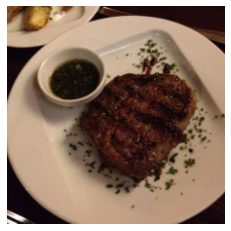

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.axis(False)

In [ ]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Image gets turned into 768 feature maps with height and width = 14.

Thus the embedding size D is 768.

Showing random convolutional feature maps from indexes: [287, 266, 473, 81, 148]


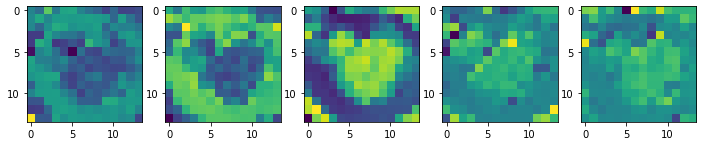

In [ ]:
# Plotting 5 random convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())


These are called **learnable embeddings** as they can change during learning.

In [ ]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.requires_grad

True

In [ ]:
single_feature_map

tensor([[[-9.5394e-02, -6.7007e-02, -1.0453e-01, -1.4090e-01, -1.4802e-01,
          -1.5349e-01,  5.4254e-02, -1.0686e-02, -7.2420e-03,  4.2799e-02,
          -5.0595e-02, -5.2602e-02, -4.6268e-02, -5.1948e-02],
         [-8.4559e-02, -9.8659e-02, -1.5352e-01, -1.1996e-01, -1.2244e-01,
          -8.4328e-02, -1.1003e-01, -1.1260e-01, -1.1609e-01, -1.0638e-01,
          -9.5394e-02,  2.7489e-02, -3.0561e-03, -1.6898e-02],
         [-1.7598e-01, -1.3584e-01, -1.2822e-01, -1.1930e-01, -1.4265e-01,
          -1.1882e-01, -1.1936e-01, -1.3051e-01, -1.4084e-01, -1.5837e-01,
          -3.4856e-02, -1.2444e-01, -7.7431e-02,  7.9834e-03],
         [-3.4700e-02,  6.3493e-03, -1.2224e-01, -9.0781e-02, -7.3992e-02,
          -1.1237e-01, -1.3663e-01, -8.8025e-02, -6.6265e-02, -9.7038e-02,
          -2.2631e-01, -1.4110e-01, -1.1239e-01, -1.0835e-01],
         [ 2.3800e-03, -1.3048e-01, -1.3283e-01, -6.0429e-02, -6.0721e-02,
          -5.8557e-02, -1.4117e-01, -1.7048e-01, -1.5913e-01, -8.9283e-02

#### 4.3 Flattening the patches with `torch.nn.Flatten`

**Desired output (1D sequence of flattened 2D patches):** (196, 768)

As given in section 3.1 of paper:
> As a special case,
the patches can have spatial size 1x1, which means that the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.

We can flatten the "spatial dimensions of the feature map" i.e. `feature_map_height` and `feature_map_width` dimensions of image_out_of_conv using `torch.nn.Flatten()`

In [ ]:
# Flatten layer
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

In [ ]:
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


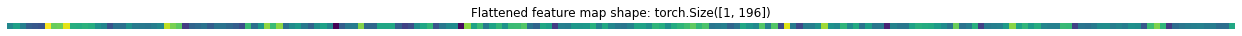

In [ ]:
# Plotting
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-9.5394e-02, -6.7007e-02, -1.0453e-01, -1.4090e-01, -1.4802e-01,
          -1.5349e-01,  5.4254e-02, -1.0686e-02, -7.2420e-03,  4.2799e-02,
          -5.0595e-02, -5.2602e-02, -4.6268e-02, -5.1948e-02, -8.4559e-02,
          -9.8659e-02, -1.5352e-01, -1.1996e-01, -1.2244e-01, -8.4328e-02,
          -1.1003e-01, -1.1260e-01, -1.1609e-01, -1.0638e-01, -9.5394e-02,
           2.7489e-02, -3.0561e-03, -1.6898e-02, -1.7598e-01, -1.3584e-01,
          -1.2822e-01, -1.1930e-01, -1.4265e-01, -1.1882e-01, -1.1936e-01,
          -1.3051e-01, -1.4084e-01, -1.5837e-01, -3.4856e-02, -1.2444e-01,
          -7.7431e-02,  7.9834e-03, -3.4700e-02,  6.3493e-03, -1.2224e-01,
          -9.0781e-02, -7.3992e-02, -1.1237e-01, -1.3663e-01, -8.8025e-02,
          -6.6265e-02, -9.7038e-02, -2.2631e-01, -1.4110e-01, -1.1239e-01,
          -1.0835e-01,  2.3800e-03, -1.3048e-01, -1.3283e-01, -6.0429e-02,
          -6.0721e-02, -5.8557e-02, -1.4117e-01, -1.7048e-01, -1.5913e-01,
          -8.9283e-02, -5

#### 4.4 Converting the ViT patch embedding layer into a Pytorch module

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence (learnable embedding vector).

    Args:
        in_channels (int): Number of color channels for the input images.
        patch_size (int): Size of patches.
        embedding_dim (int): Size of embedding to turn image into.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # Layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1) #Final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
set_seeds()

# Creating an instance
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape :{patch_embedded_image.shape}")

Output patch embedding shape :torch.Size([1, 196, 768])


In [ ]:
#get summary
summary(PatchEmbedding(),
        input_size=(1, 3, 224, 224), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#### 4.5 Creating the class token embedding

Class token embedding refers to x[class].

The second paragraph in the ViT paper section 3.1 says:
> Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches, whose state at the output of the Transformer encoder serves as the image representation y.

In [ ]:
# View the image patch embedding and patch embedding shape
print(patch_embedded_image)

tensor([[[-0.2886,  0.0914, -0.2560,  ...,  0.3314, -0.1461,  0.1879],
         [-0.5853,  0.1546, -0.0881,  ...,  0.3348, -0.2351,  0.0798],
         [-0.7437,  0.1509, -0.1752,  ...,  0.2153, -0.1483,  0.3621],
         ...,
         [-0.5362,  0.0954,  0.0065,  ...,  0.1714, -0.2284,  0.2105],
         [ 0.0119, -0.0877,  0.0265,  ...,  0.1657, -0.2791,  0.0382],
         [-0.0924, -0.0067, -0.0271,  ...,  0.0555, -0.0406,  0.0089]]],
       grad_fn=<PermuteBackward0>)


In [ ]:
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To "prepend a learnable embedding to the sequence of embedded patches" we create a learnable embedding in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension.(dim=1)

We get the batch size and embedding dimension shape and then we create a `torch.ones()` tensor in the shape [batch_size, 1, embedding_dimension].

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure the embedding is learnable

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, num_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2886,  0.0914, -0.2560,  ...,  0.3314, -0.1461,  0.1879],
         [-0.5853,  0.1546, -0.0881,  ...,  0.3348, -0.2351,  0.0798],
         ...,
         [-0.5362,  0.0954,  0.0065,  ...,  0.1714, -0.2284,  0.2105],
         [ 0.0119, -0.0877,  0.0265,  ...,  0.1657, -0.2791,  0.0382],
         [-0.0924, -0.0067, -0.0271,  ...,  0.0555, -0.0406,  0.0089]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, num_of_patches, embedding_dimension]


#### 4.6 Position embedding

From section 3.1 of paper:

>Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

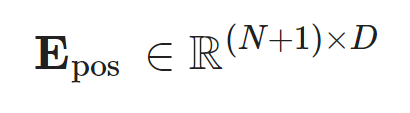

- N is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
- D is the size of the patch embeddings, different values for  can be found in Table 1 (embedding dimension).

In [ ]:
# N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad=True)

# Show the first 10 sequences and 10 position embedding values
print(position_embedding[:, :10, :10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [ ]:
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, num_patches, embedding_size]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7114, 1.0914, 0.7440,  ..., 1.3314, 0.8539, 1.1879],
         [0.4147, 1.1546, 0.9119,  ..., 1.3348, 0.7649, 1.0798],
         ...,
         [0.4638, 1.0954, 1.0065,  ..., 1.1714, 0.7716, 1.2105],
         [1.0119, 0.9123, 1.0265,  ..., 1.1657, 0.7209, 1.0382],
         [0.9076, 0.9933, 0.9729,  ..., 1.0555, 0.9594, 1.0089]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, num_patches, embedding_size]


#### 4.7 Putting it together

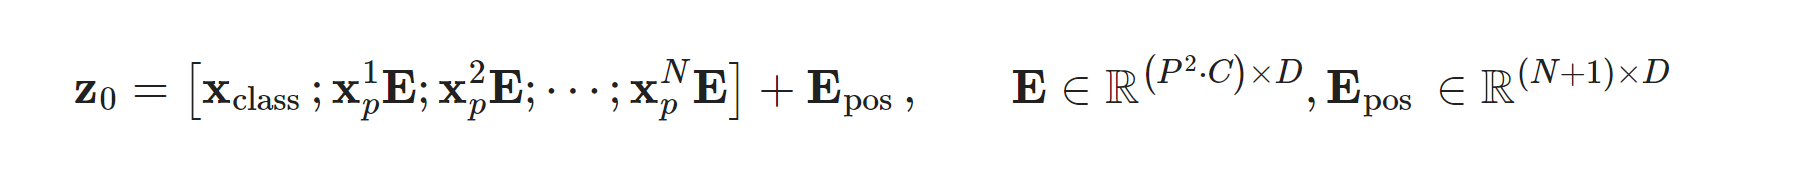

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Add batch dimension
x = image.unsqueeze(0)
print(f"Input image (with batch dimension) shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image this layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8.Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9.Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image (with batch dimension) shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. **Equation 2: Multi-Head Attention(MSA)**

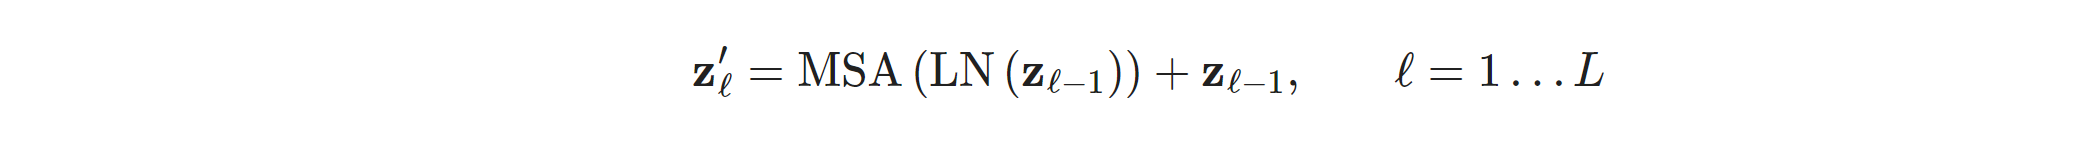

The Multi-Head Attention (MSA)  layer is wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

Implementing the MSA Layer using `torch.nn.MultiheadAttention` with parameters:

- `embed_dim`: embedding dimension from Table 1 (hidden size D)
- `num_heads`: number of attention heads to use (value given in Table 1)
- `dropout`: whether to apply dropout to attention layer (not applied, according to Appendix B.1)
- `batch_first`: does batch dim come first

In [ ]:
# 1. Creating MSA block
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block
    """
    # 2. Initialize the class with hyperparameters from Table 1 of base paper
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    # 5. Create a forward() method
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, #query embeddings
                                             key=x, #key embeddings
                                             value=x, #value embeddings
                                             need_weights=False)
        return attn_output

In [ ]:
# Creating an instance
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. **Equation 3: Multiplayer Perceptron (MLP)**

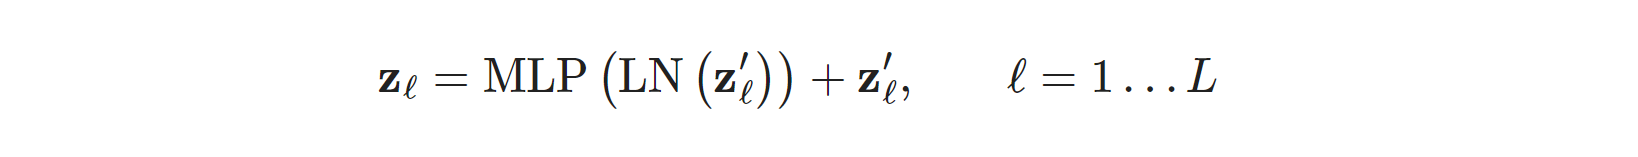

Term on the right is the skip/residual connection.

General pattern in MLP:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In case of ViT paper, as given in section 3.1:
> The MLP contains two layers with a GELU non-linearity.

Appendix B.1 (Training):
> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.

This means there is dropout after every linear/dense layer in the MLP. The value of which can be found in Table 3 of the ViT paper (dropout=0.1).

Hence, the structure of the MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

MLP size is the number of hidden units between the linear layers and hidden size  is the output size of the MLP block.



In [ ]:
# 1. Create a class for MLP Block
class MLPBlock(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, #Hidden Size D from Table1 for ViT-Base
                 mlp_size:int=3072, #MLP size from Table 1 for ViT-Base
                 dropout:int=0.1): #Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Creating the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Creating the Multilayer perceptron (MLP) layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), #back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Creating a forward() method
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Creating an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # Table 1
                     mlp_size=3072, # Table 1
                     dropout=0.1) # Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

Now we stack the MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.

The Transformer Encoder encodes the patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

Residual conncection is obtained by adding a layers input to it's subsequent output.

#### 7.1 Creating Transformer Encoder by combining custom made layers

In [ ]:
# 1. Create a class
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initializing the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:int=0.1, # Table 3
                 attn_dropout:int=0):
        super().__init__()

        # 3. Creating the MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Creating an MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Creating a residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Creating a residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, #Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, #Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, #MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## 8. **Equation 4: Creating Vision Transformer**

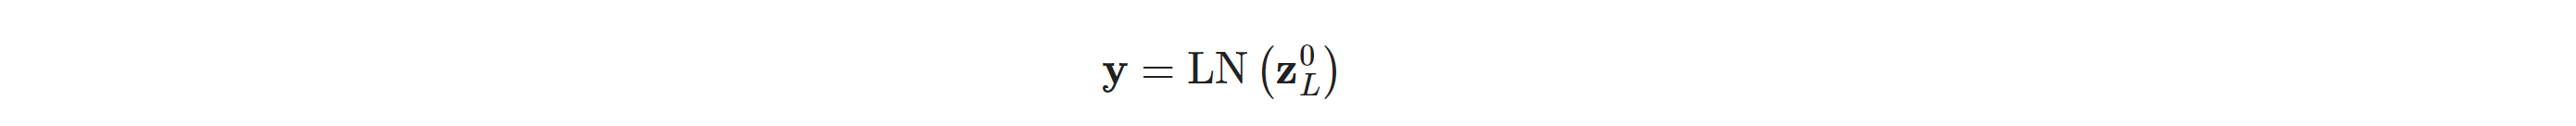

We need a torch.nn.LayerNorm() layer and a torch.nn.Linear() layer to convert the 0th index (
) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our TransformerEncoderBlocks on top of each other, we can do this by passing a list of them to torch.nn.Sequential()

In [ ]:
# 1. Creating a ViT class
class ViT(nn.Module):
    """
    Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
    """
    # 2. Initializing the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, #Training resolution from Table 3 in ViT paper
                 in_channels:int=3, #Color channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet
        super().__init__()

        # 3. Making sure the image size is divisble by the patch size
        assert img_size%patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4.Number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks
        self.transformer_enedoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1,-1)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat( (class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        #18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_enedoder(x)

        #19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape expanded: torch.Size([32, 1, 768])


In [ ]:
#trying an example on ViT
random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[ 0.0768,  0.1724, -0.0080]], grad_fn=<AddmmBackward0>)

## 9. Training code for ViT model

#### 9.1 Creating an optimizer and loss function

Section 4.1 of the paper:
>Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with beta1=0.9 and beta2=0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

Hence, we use Adam optimizer along with CrossEntropy for loss.

#### 9.2 Training the model

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001, #Base LR from Table 3 = 1e-3
                             betas=(0.9, 0.999),
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3283 | train_acc: 0.3320 | test_loss: 2.3867 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.7991 | train_acc: 0.2891 | test_loss: 1.5516 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.5696 | train_acc: 0.2969 | test_loss: 1.6262 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.6202 | train_acc: 0.3086 | test_loss: 1.6026 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.4976 | train_acc: 0.4297 | test_loss: 1.1611 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.3337 | train_acc: 0.2695 | test_loss: 1.4218 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1843 | train_acc: 0.3789 | test_loss: 1.3052 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1144 | train_acc: 0.4492 | test_loss: 1.0603 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.3441 | train_acc: 0.2773 | test_loss: 1.1667 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1598 | train_acc: 0.2734 | test_loss: 1.0891 | test_acc: 0.5417


#### 9.4 Loss curves

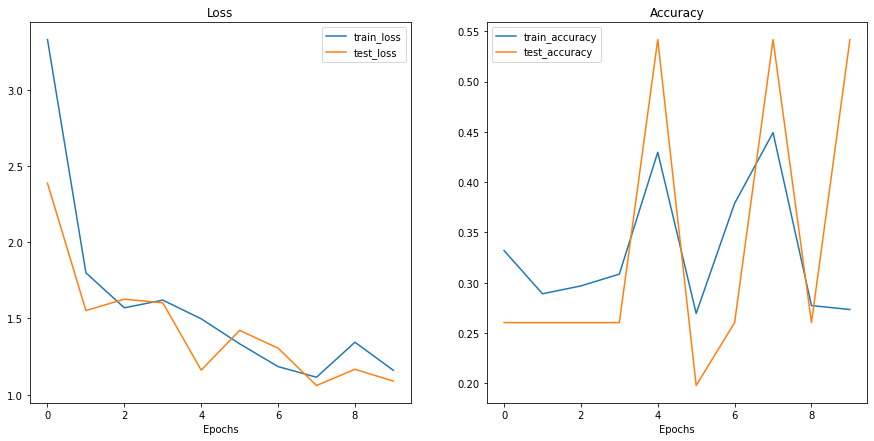

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

#### 10.1 Getting a pretrained ViT model and creating a feature extractor

In [ ]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1.Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2.Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3.Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4.Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]
├─Encoder (encoder)                                          [32, 197, 768]
│    └─Dropout (dropout)                                     [32, 197, 768]
│    └─Sequential (layers)                                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_3)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_4)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_5)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_6)                   [32, 197, 768]
│    │   

#### 10.2 Preparing data

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

#### 10.3 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


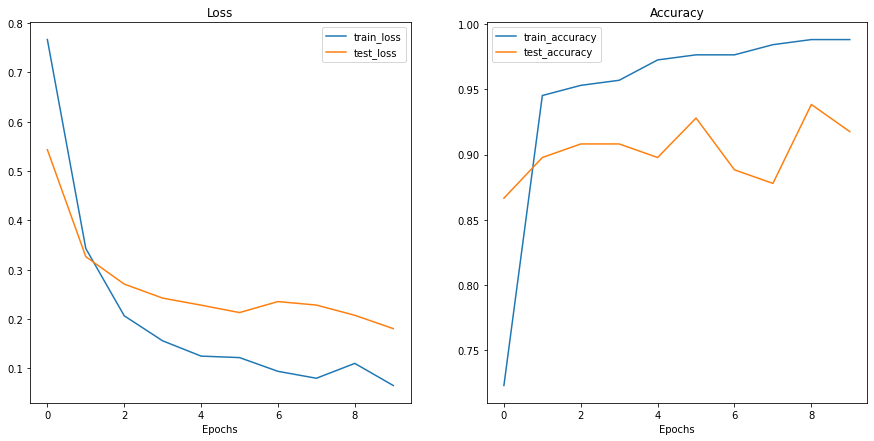

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
# Saving the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth
